In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# visualize graph

from graphviz import Digraph


def trace(root):
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges


def draw_dot(root, format="svg", rankdir="LR"):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ["LR", "TB"]
    nodes, edges = trace(root)
    dot = Digraph(
        format=format, graph_attr={"rankdir": rankdir}
    )  # , node_attr={'rankdir': 'TB'})

    for n in nodes:
        dot.node(
            name=str(id(n)),
            label="{ %s| data %.4f | grad %.4f }" % (n.label, n.data, n.grad),
            # label="{ %s| data %.4f  }" % (n.label, n.data),
            shape="record",
        )
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [3]:
#  so to solve this we'll modify add


# self._prev:  but how are we going to show connectiveness of these numbers as we want to keep expression graphs. to keep track of what values produce other values
# _op='': to track which operation on children created new node


#  building Value Object: data structure to mantain these numerical expressions
class Value:
    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self._backward = (
            lambda: None
        )  # for chain rule but by default it doesnot do anything  # a case for leaf node
        self.label = label
        self.grad = 0.0

    def __repr__(self) -> str:
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(
            self.data + other.data, (self, other), "+"
        )  # here (self, other) are _children

        def _backward():
            self.grad += 1.0 * out.grad  # 1.0 for addition
            other.grad += 1.0 * out.grad

        out._backward = _backward
        return out

    def __radd__(self, other):
        return self + other  # Call regular addition method for consistency

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*")

        def _backward():
            self.grad += other.data * out.grad  # 1.0 for addition
            other.grad += self.data * out.grad

        out._backward = _backward

        return out

    def __rmul__(
        self, other
    ):  # other*self   # this will check if 2*a can not happen, so can a*2 happen?
        # print("rmul")
        return self * other  # changing order and redirecting to __mul__

    def __pow__(self, other):
        assert isinstance(
            other, (int, float)
        ), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f"**{other}")

        def _backward():
            self.grad = other * self.data ** (other - 1) * out.grad  # n(x)^(n-1)

        out._backward = _backward

        return out

    def __truediv__(self, other):
        # print(f"self:{self},other:{other}, self * (other ** (-1): {(other * (-1))}")

        return self * (other ** (-1))

    def tanh(self):
        x = self.data
        t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)  # tanh
        out = Value(t, (self,), "tanh")

        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), "exp")

        def _backward():
            self.grad += out.data * out.grad

        out._backward = _backward
        return out

    def __neg__(self):  # -self
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def backward(self):

        # topological ordering

        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)

                topo.append(v)

        build_topo(self)  # o would be at last o list

        self.grad = 1.0
        for node in reversed(topo):

            node._backward()

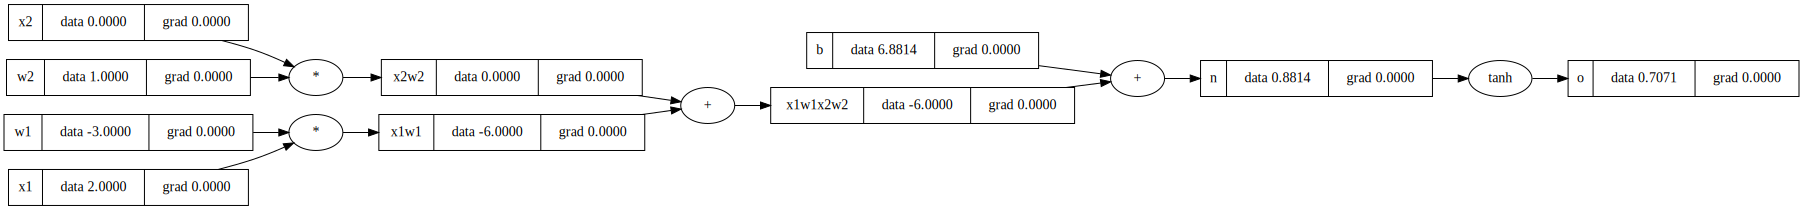

In [4]:
#  a neuron with two inputs: x1,x2

x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")
# weights
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
b = Value(6.88137358, label="b")

x1w1 = x1 * w1
x1w1.label = "x1w1"

x2w2 = x2 * w2
x2w2.label = "x2w2"

x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = "x1w1x2w2"
# adding bias
n = x1w1x2w2 + b
n.label = "n"
# activation function
o = n.tanh()
o.label = "o"


draw_dot(o)